In [1]:
#Import Required Libraries
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
import seaborn as sns
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

In [2]:
def plot_learning_curve_hyper(df, x_axis_label, y_axis_label, title, ax=None, ylim=None):
  x = []
  for ele in df.params:
    for k, v in ele.items():
      x.append(str(v))
  if ax is None:
    _, ax = plt.subplots(figsize=(14, 10))

  ax.set_title(title)
  if ylim is not None:
    ax.set_ylim(*ylim)
  ax.set_xlabel(x_axis_label)
  ax.set_ylabel(y_axis_label)
  ax.grid()
  ax.fill_between(
    x,
    (df['mean_train_score'] - df['std_train_score']).values,
    (df['mean_train_score'] + df['std_train_score']).values,
    alpha=0.1,
    color="r",
    )
  ax.fill_between(
    x,
    (df['mean_test_score'] - df['std_test_score']).values,
    (df['mean_test_score'] + df['std_test_score']).values,
    alpha=0.1,
    color="g",
    )
  ax.plot(x, df['mean_train_score'], "x-", color = 'r', label = 'Training Score')
  ax.plot(x, df['mean_test_score'], "x-", color = 'g', label = 'Cross-validation Score')
  ax.legend(loc="best")

In [3]:
def plot_learning_curve(model, X, y, X_train=None, X_val=None, y_train=None, y_val=None):

  if X_train is None: 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=27)
  train_errors, val_errors = [], []
  train_size = np.linspace(10, len(X_train), 10).astype(int)
  for m in train_size:
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)

    train_errors.append(f1_score(y_train[:m], y_train_predict, average='macro'))
    val_errors.append(f1_score(y_val, y_val_predict, average= 'macro'))
  plt.grid()
  plt.plot(train_size, train_errors, 'r', label= 'Training Error')
  plt.plot(train_size, val_errors, 'b', label = 'Validation Error')
  plt.ylabel('F1 Macro Score')
  plt.xlabel('Training Example Size')
  plt.legend(loc='best')

In [4]:
def up_sampling(X_train, y_train):
  #Concatonate our our training data back together
  X = pd.concat([X_train, y_train], axis=1)
  #Seprate Minority and Majority Class
  opened_account = X[X['Personal Loan'] == 1]
  not_opened_account = X[X['Personal Loan'] == 0]
  #Upsample the Minority Class
  opened_account_upsampled = resample(opened_account,
                                      replace = True, #sample with replacement
                                      n_samples= len(not_opened_account), #match the number of not opened account
                                      random_state = 27)
  upsampled = pd.concat([opened_account_upsampled, not_opened_account])
  return upsampled

In [5]:
def down_sampling(X_train, y_train):
  #Concatonate our our training data back together
  X = pd.concat([X_train, y_train], axis=1)
  #Seprate Minority and Majority Class
  opened_account = X[X['Personal Loan'] == 1]
  not_opened_account = X[X['Personal Loan'] == 0]
  #Down sample the majority class
  not_opened_account_downsample = resample(not_opened_account,
                                           replace = False,
                                           n_samples = len(opened_account),
                                           random_state= 27)
  downsample = pd.concat([opened_account, not_opened_account_downsample])
  
  return downsample

In [6]:
def synthetic_samples(X_train, y_train, ratio):
  sm = SMOTE(random_state=27, ratio = ratio)
  X_train, y_train = sm.fit_sample(X_train, y_train)

  return X_train, y_train


In [7]:
#Mount to Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
% cd /content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT

/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT


In [9]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name= 'Data')

In [10]:
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937913,1.747666,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


In [12]:
#Replacing Negative Values in Experience Column with Zeros
df[df['Experience'] < 0] = abs(df[df['Experience'] < 0])

In [13]:
#View Summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


There is a hug class imbalance

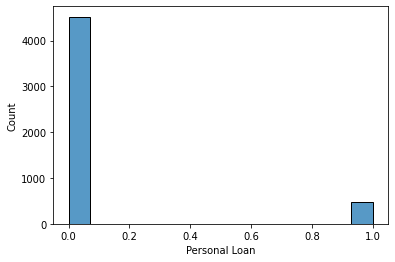

In [14]:
#Check Class Imbalance
sns.histplot(df['Personal Loan'])

In [15]:
y = df['Personal Loan']
X = df.drop(['Personal Loan', 'ID', 'ZIP Code'], axis=1)
print(f'Target Dimension: {y.shape}')
print(f'Feature Dimensions: {X.shape}')

Target Dimension: (5000,)
Feature Dimensions: (5000, 11)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f7b527890>,
      dtype=object)

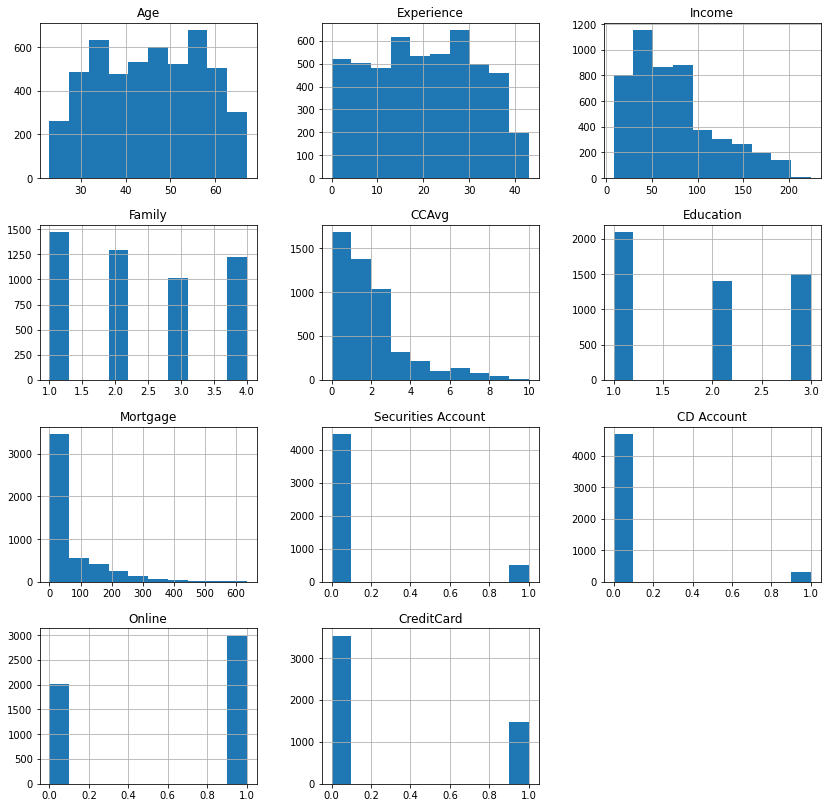

In [ ]:
X.hist(figsize=(14,14))

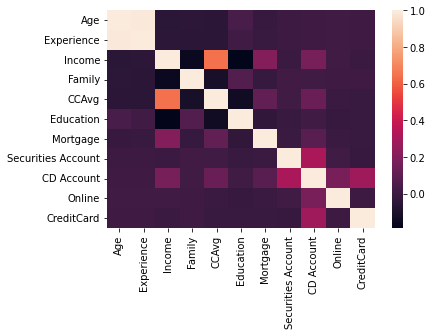

In [16]:
corr = X.corr()
sns.heatmap(corr)

In [ ]:
corr

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
Age,1.000000,0.993991,-0.055269,-0.046418,-0.052030,0.041334,-0.012539,-0.000436,0.008043,0.013702,0.007681
Experience,0.993991,1.000000,-0.046876,-0.051851,-0.049750,0.013919,-0.011097,-0.000989,0.009735,0.014051,0.008851
Income,-0.055269,-0.046876,1.000000,-0.157501,0.645993,-0.187524,0.206806,-0.002616,0.169738,0.014206,-0.002385
Family,-0.046418,-0.051851,-0.157501,1.000000,-0.109285,0.064929,-0.020445,0.019994,0.014110,0.010354,0.011588
CCAvg,-0.052030,-0.049750,0.645993,-0.109285,1.000000,-0.136138,0.109909,0.015087,0.136537,-0.003620,-0.006686
Education,0.041334,0.013919,-0.187524,0.064929,-0.136138,1.000000,-0.033327,-0.010812,0.013934,-0.015004,-0.011014
Mortgage,-0.012539,-0.011097,0.206806,-0.020445,0.109909,-0.033327,1.000000,-0.005411,0.089311,-0.005995,-0.007231
Securities Account,-0.000436,-0.000989,-0.002616,0.019994,0.015087,-0.010812,-0.005411,1.000000,0.317034,0.012627,-0.015028
CD Account,0.008043,0.009735,0.169738,0.014110,0.136537,0.013934,0.089311,0.317034,1.000000,0.175880,0.278644
Online,0.013702,0.014051,0.014206,0.010354,-0.003620,-0.015004,-0.005995,0.012627,0.175880,1.000000,0.004210


In [17]:
#Dropping Age column for colinearity
X.drop('Age', axis=1, inplace=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y, random_state=27)

In [19]:
#Try Quick and Dirty Decision Tree
clf_dt = DecisionTreeClassifier(random_state=0)

clf_dt.fit(X_train, y_train)

y_pred = clf_dt.predict(X_test)

print(f'Classification Report on Test Set Using Naive Decision Tree:\n\n {classification_report(y_pred, y_test)}')


Classification Report on Test Set Using Naive Decision Tree:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1124
           1       0.91      0.87      0.89       126

    accuracy                           0.98      1250
   macro avg       0.95      0.93      0.94      1250
weighted avg       0.98      0.98      0.98      1250



In [20]:
print(f'Classification Report on Test Set Using Naive Decision Tree:\n\n {classification_report(y_train, clf_dt.predict(X_train))}')

Classification Report on Test Set Using Naive Decision Tree:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3390
           1       1.00      1.00      1.00       360

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750



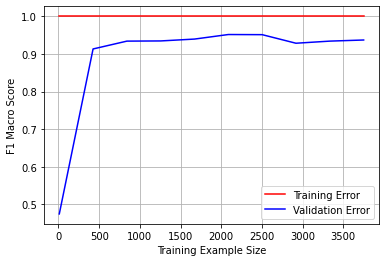

In [21]:
plot_learning_curve(clf_dt, X, y)

In [22]:
# Exploring Hyperparameters Through Grid Search
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=0)

param_grid = {'criterion': ['gini', 'entropy']}

grid_search = GridSearchCV(clf, param_grid = param_grid, scoring='f1_macro',
                           return_train_score=True, cv =4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy']},
             return_train_score=True, scoring='f1_macro')

In [23]:
df_criterion = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'criterion': 'entropy'}

In [24]:
df_criterion

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.006735,0.000563,0.003435,0.000288,gini,{'criterion': 'gini'},0.941329,0.960642,0.945301,0.942387,0.947415,0.007774,2,1.0,1.0,1.0,1.0,1.0,0.0
1,0.005995,0.000530,0.003213,0.000211,entropy,{'criterion': 'entropy'},0.943570,0.966697,0.959447,0.931716,0.950357,0.013630,1,1.0,1.0,1.0,1.0,1.0,0.0


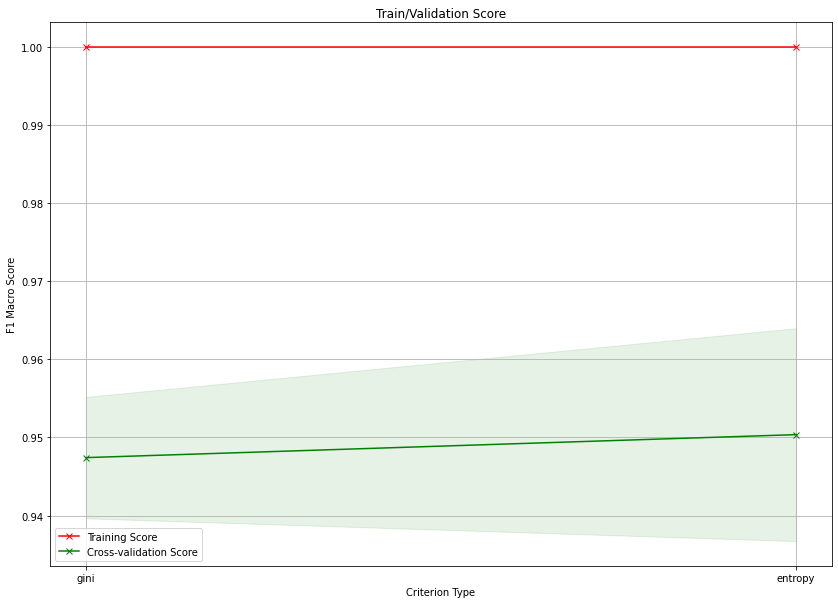

In [ ]:
plot_learning_curve_hyper(df_criterion, 'Criterion Type', 'F1 Macro Score',
                          'Train/Validation Score')

In [ ]:
# Exploring Hyperparameters Through Grid Search
# Splitter Parameter
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=0)

param_grid = {'splitter': ['best', 'random']}

grid_search = GridSearchCV(clf, param_grid =param_grid, scoring='f1_macro',
                           return_train_score=True, cv =4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'splitter': ['best', 'random']},
             return_train_score=True, scoring='f1_macro')

In [ ]:
df_splitter = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'splitter': 'best'}

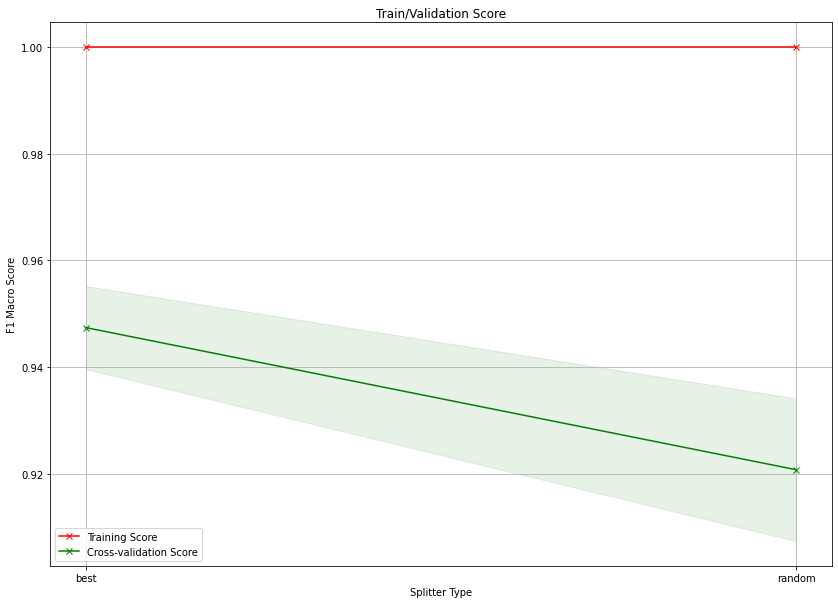

In [ ]:
plot_learning_curve_hyper(df_splitter, 'Splitter Type', 'F1 Macro Score',
                          'Train/Validation Score')

In [ ]:
# Exploring Hyperparameters Through Grid Search
# max_depth Parameter
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=0)

param_grid = {'max_depth': [i for i in range(4, 30)]}

grid_search = GridSearchCV(clf, param_grid =param_grid, scoring='f1_macro',
                           return_train_score=True, cv =4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                       16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                       26, 27, 28, 29]},
             return_train_score=True, scoring='f1_macro')

In [ ]:
df_depth = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'max_depth': 6}

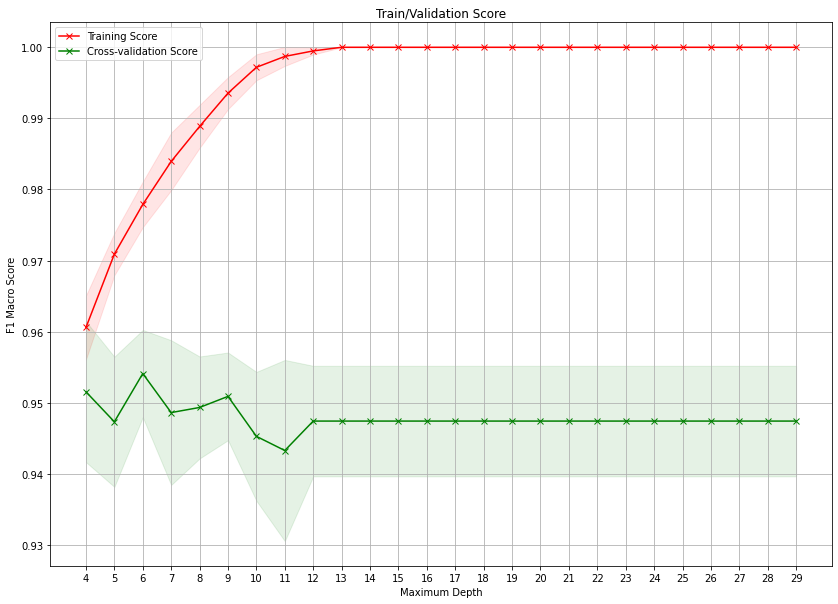

In [ ]:
plot_learning_curve_hyper(df_depth, 'Maximum Depth', 'F1 Macro Score',
                          'Train/Validation Score')

In [ ]:
# Exploring Hyperparameters Through Grid Search
# Min_samples_split Parameter
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=0)

param_grid = {'min_samples_split': [i for i in range(2, 40)]}

grid_search = GridSearchCV(clf, param_grid =param_grid, scoring='f1_macro',
                           return_train_score=True, cv =4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 29, 30, 31, ...]},
             return_train_score=True, scoring='f1_macro')

In [ ]:
df_min_split = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'min_samples_split': 34}

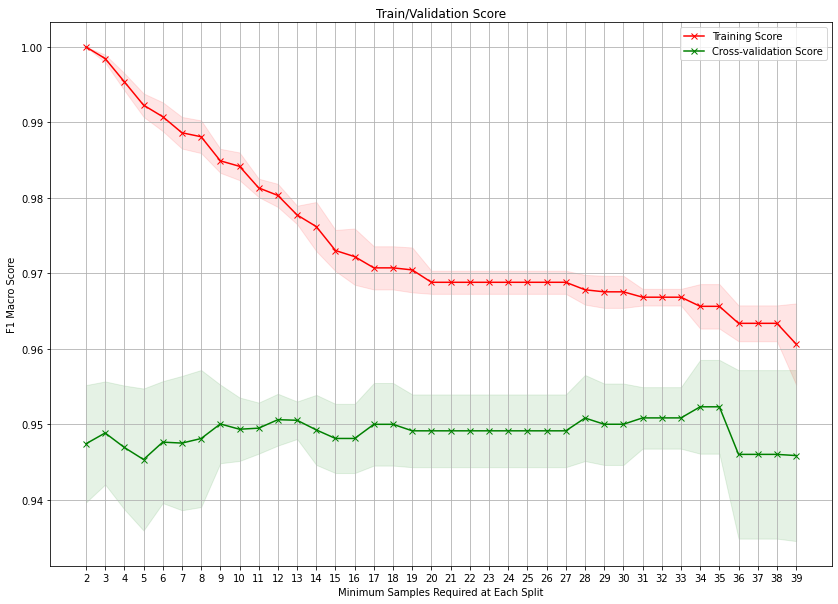

In [ ]:
plot_learning_curve_hyper(df_min_split, 'Minimum Samples Required at Each Split', 'F1 Macro Score',
                          'Train/Validation Score')

In [ ]:
# Exploring Hyperparameters Through Grid Search
# Min_samples_leaf Parameter
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=0)

param_grid = {'min_samples_leaf': [i for i in range(2, 30)]}

grid_search = GridSearchCV(clf, param_grid =param_grid, scoring='f1_macro',
                           return_train_score=True, cv =4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             return_train_score=True, scoring='f1_macro')

In [ ]:
df_min_leaf = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'min_samples_leaf': 10}

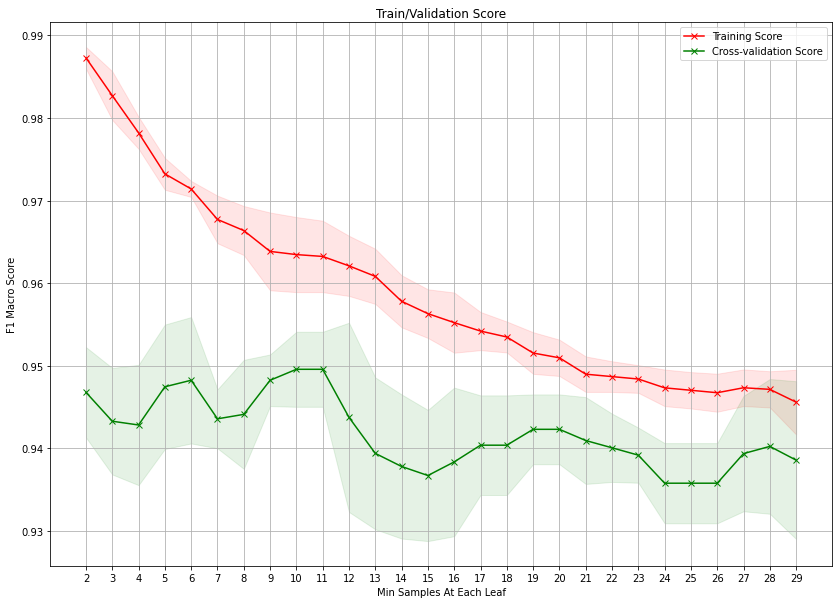

In [ ]:
plot_learning_curve_hyper(df_min_leaf, 'Min Samples At Each Leaf', 'F1 Macro Score',
                          'Train/Validation Score')

In [ ]:
# Exploring Hyperparameters Through Grid Search
# Max_features Parameter
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=0)

# param_grid = {'max_features': ['auto', X_train.shape[1], 'log2', 0.9, 0.8, 0.7, 0.6]}

param_grid = {'max_features': np.arange(0.3,1.1, 0.1).round(2)}

grid_search = GridSearchCV(clf, param_grid =param_grid, scoring='f1_macro',
                           return_train_score=True, cv =4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_features': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             return_train_score=True, scoring='f1_macro')

In [ ]:
df_max_features = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'max_features': 0.5}

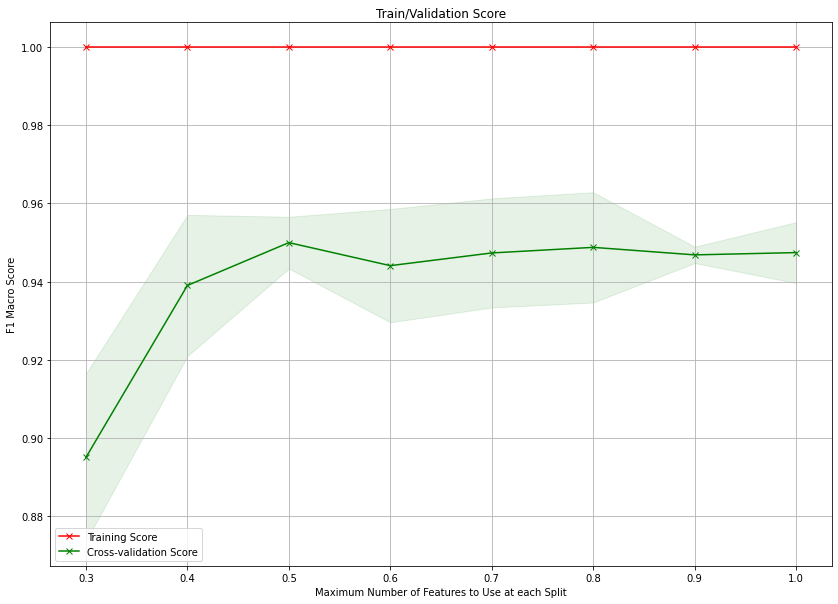

In [ ]:
plot_learning_curve_hyper(df_max_features, 'Maximum Number of Features to Use at each Split', 'F1 Macro Score',
                          'Train/Validation Score')

In [ ]:
# Exploring Hyperparameters Through Grid Search
# Class_weight Parameter
from sklearn.model_selection import GridSearchCV

int_max_feature = X_train.shape[1] 
clf = DecisionTreeClassifier(random_state=0)

param_grid = {'class_weight': ['balanced', None]}

grid_search = GridSearchCV(clf, param_grid =param_grid, scoring='f1_weighted',
                           return_train_score=True, cv =4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'class_weight': ['balanced', None]},
             return_train_score=True, scoring='f1_weighted')

In [ ]:
df_class_weight = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'class_weight': 'balanced'}

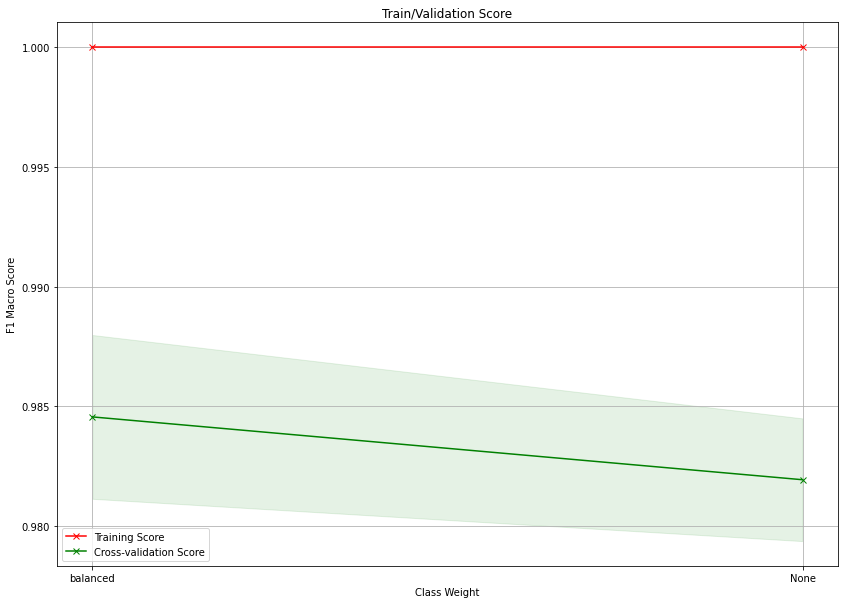

In [ ]:
plot_learning_curve_hyper(df_class_weight, 'Class Weight', 'F1 Macro Score',
                          'Train/Validation Score')

In [ ]:
from seaborn.axisgrid import Grid
#Final Model
# criterion='entropy',
# max_depth=6, min_samples_split=34,
# min_samples_leaf=10, splitter='best',
# max_features=0.5, class_weight='balanced'



clf_dt = DecisionTreeClassifier(random_state=0)

param_grid = [{'criterion': ['gini', 'entropy'],
               'max_depth': [i for i in range(4, 10)],
               'min_samples_split': [i for i in range(26,32)],
               'min_samples_leaf': [i for i in range(4,10)],
               'splitter': ['random', 'best'],
               'class_weight': ['balanced', None],
               'max_features': np.arange(0.6,1.1, 0.1)}]


grid_search = GridSearchCV(clf_dt, param_grid= param_grid, scoring='f1_macro',
                           return_train_score=True, cv=4, n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid=[{'class_weight': ['balanced', None],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [4, 5, 6, 7, 8, 9],
                          'max_features': array([0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
                          'min_samples_leaf': [4, 5, 6, 7, 8, 9],
                          'min_samples_split': [26, 27, 28, 29, 30, 31],
                          'splitter': ['random', 'best']}],
             return_train_score=True, scoring='f1_macro')

In [ ]:
# final_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0,
#                                      max_depth= 7, max_features= 0.8999999999999999,
#                                      min_samples_leaf= 4, min_samples_split= 30,
#                                      splitter= 'best')
# final_model.fit(X_train, y_train)

final_model = grid_search.best_estimator_
print(grid_search.best_params_)


{'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 0.8999999999999999, 'min_samples_leaf': 4, 'min_samples_split': 30, 'splitter': 'best'}


In [ ]:
y_pred = final_model.predict(X_test)
print(f"F1 Weighted Score on Test Set: {f1_score(y_test, y_pred, average='macro'):.2f}")
print(f'\nClassification report on test set:\n\n {classification_report(y_test, y_pred, zero_division=1)}')
print(f'\nClassification report on training set:\n\n {classification_report(y_train, final_model.predict(X_train), zero_division=1)}')

F1 Weighted Score on Test Set: 0.98

Classification report on test set:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1130
           1       0.90      0.92      0.91       120

    accuracy                           0.98      1250
   macro avg       0.95      0.95      0.95      1250
weighted avg       0.98      0.98      0.98      1250


Classification report on training set:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3390
           1       0.95      0.92      0.94       360

    accuracy                           0.99      3750
   macro avg       0.97      0.96      0.96      3750
weighted avg       0.99      0.99      0.99      3750



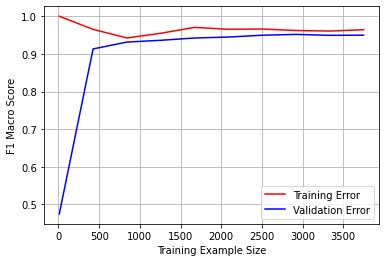

In [ ]:
plot_learning_curve(final_model, X, y, X_train = X_train, y_train = y_train,
                    X_val = X_test, y_val= y_test)